# Imports

In [1]:
import math
import pandas as pd
import numpy as np
import glob
import datetime
from calendar import monthrange
pd.options.mode.chained_assignment = None

%matplotlib inline

# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### Constants

In [3]:
DEFAULT_NAME_COLUMN_DATE = 'Date'
DEFAULT_NAME_COLUMN_DESCRIPTION = 'Description'
DEFAULT_NAME_COLUMN_TOTAL = 'Totals'
DEFAULT_NAME_COLUMN_COUNTRY = 'Country'

DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES = 'New cases'
DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS = 'New deaths'

DEFAULT_DATA_FORMAT = '%Y-%m-%d'

### Auxiliary functions

In [4]:
def sanitize_date(date, original_formats):
    '''
    Transform a date specified in a string with a certain original
    format into a string with the date in the default format.
    '''
    date_rep = None
    try:
        date_rep = datetime.datetime.strptime(date, original_formats[0])
    except ValueError:
        date_rep = datetime.datetime.strptime(date, original_formats[1])
    return date_rep.strftime(DEFAULT_DATA_FORMAT)

In [5]:
def estimate_daily_from_cum(np_list):
    '''
    Given a list of accumulated data, calculate the data for each day.
    It assumes ordered data.
    '''
    last_known_n = -1
    final_list = list()
    for i, elem in np_list.iteritems():
        #elem = float(elem)
        if (math.isnan(elem)):
            final_list.append(0)
        else:
            if (last_known_n == -1):
                final_list.append(0)
            else:
                final_list.append(elem - last_known_n)
            last_known_n = elem
    return np.array(final_list)

We define dictionaries with values for each country

In [6]:
country_keys = ['guinea', 'liberia', 'sl']
paths = {x: DATA_FOLDER + '/ebola/'+ x + '_data' for x in country_keys}
countries = {'guinea': 'Guinea', 'liberia': 'Liberia', 'sl': 'Sierra Leone'}

wanted_columns = {'guinea': ['Date', 'Description', 'Totals'],
                      'liberia': ['Date', 'Variable', 'National'],
                      'sl': ['date', 'variable', 'National']}

date_original_formats = {'guinea': ['%Y-%m-%d', '%y-%m-%d'],
                         'liberia': ['%m/%d/%Y', '%m/%d/%y'],
                         'sl': ['%Y-%m-%d', '%y-%m-%d']}
dataframe_list = {}

### Read files

In [7]:
for i in country_keys:
    temp_list = []
    all_files = glob.glob(paths[i] + '/*.csv')
    for file in all_files:
        temp_df = pd.read_csv(file)
        temp_list.append(temp_df)
    dataframe_list[i] = pd.concat(temp_list)
    
    # Format dates and order dataframes by date
    dataframe_list[i][wanted_columns[i][0]] = np.array([sanitize_date(x, date_original_formats[i])
                                                        for x in dataframe_list[i][wanted_columns[i][0]]])
    
    dataframe_list[i][wanted_columns[i][0]] = pd.to_datetime(dataframe_list[i][wanted_columns[i][0]])
    dataframe_list[i].sort_values(by=wanted_columns[i][0])

### Parsing functions

For Guinea, we are considering the variables 'New deaths registered' and 'New deaths registered today', which were defined for all of the dates present in the data files.

In [8]:
def parse_guinea_files():
    # Select certain column from the CSV formatted files
    parsed_guinea_df = dataframe_list['guinea'][wanted_columns['guinea']]
    wanted_row_list = ['Total new cases registered so far',
                       'New deaths registered', 
                       'New deaths registered today']
    
    # Select all the rows that match desired names for 'Description' column
    parsed_guinea_df = parsed_guinea_df[parsed_guinea_df['Description'].isin(wanted_row_list)]
    
    # Rename every row value for 'Description' column 
    parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                         wanted_row_list[0], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES
    
    parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                         wanted_row_list[1], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS
    
    parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                         wanted_row_list[2], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS
    
    # Add 'Country' column to dataframe
    parsed_guinea_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['guinea']
    
    return parsed_guinea_df

Sample:

In [9]:
parse_guinea_files().head()

,Date,Description,Totals,Country
3,2014-08-26,New cases,28,Guinea
9,2014-08-26,New deaths,5,Guinea
3,2014-09-23,New cases,29,Guinea
9,2014-09-23,New deaths,3,Guinea
3,2014-09-04,New cases,30,Guinea


##### Explain Liberia parsing

In [10]:
def parse_liberia_files():
    # Select certain columns from the CSV formatted files
    liberia_df = dataframe_list['liberia'][wanted_columns['liberia']]

    wanted_row_list = ['New Case/s (Suspected)',
                       'New Case/s (Probable)',
                       'New case/s (confirmed)',
                       'Newly reported deaths',
                       'Total suspected cases',
                       'Total probable cases',
                       'Total confirmed cases']

    # Create temporary dataframe for new case entries
    # (with every row that matches the desired 'Variables' column value)
    liberia_df_new_cases_cum_1 = liberia_df[liberia_df['Variable'].isin(wanted_row_list[4:7])]
    liberia_df_new_cases_cum_1 = liberia_df_new_cases_cum_1[liberia_df_new_cases_cum_1['Date'].map(
        lambda x: x.month == 12 and x.day <= 3)]
    liberia_df_new_cases_cum_1 = liberia_df_new_cases_cum_1.groupby('Date').sum()
    
    liberia_df_new_cases_cum_2 = liberia_df[liberia_df['Variable'].isin(wanted_row_list[0:3])]
    liberia_df_new_cases_cum_2 = liberia_df_new_cases_cum_2[liberia_df_new_cases_cum_2['Date'].map(
        lambda x: x.month == 12 and x.day > 3)]
    liberia_df_new_cases_cum_2 = liberia_df_new_cases_cum_2.groupby('Date').sum()
    
    liberia_df_new_cases_cum = pd.concat([liberia_df_new_cases_cum_1, liberia_df_new_cases_cum_2])

    
    liberia_df_new_cases_cum['National'] = estimate_daily_from_cum(liberia_df_new_cases_cum['National'])
    
    liberia_df_new_cases = liberia_df[liberia_df['Variable'].isin(wanted_row_list[0:3])]
    liberia_df_new_cases = liberia_df_new_cases[liberia_df_new_cases['Date'].map(
        lambda x: x.month != 12)]
    
    liberia_df_new_cases = pd.concat([liberia_df_new_cases, liberia_df_new_cases_cum])
    
    # Sum all of the values for 'Probable', 'Variable' and 'Confirmed' new cases
    liberia_df_new_cases = liberia_df_new_cases.groupby('Date').sum()

    liberia_df_new_cases['Date'] = liberia_df_new_cases.index
    liberia_df_new_cases['Variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES
    
    # Create temporary dataframe for new deaths entries
    liberia_df_new_deaths = liberia_df[liberia_df['Variable'] == wanted_row_list[3]]
    liberia_df_new_deaths['Variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS
    
    # Create new dataframe with new deaths and cases (concatenating the two temporary)
    parsed_liberia_df = pd.concat([liberia_df_new_cases, liberia_df_new_deaths])
    
    parsed_liberia_df.rename(columns={'Date': DEFAULT_NAME_COLUMN_DATE,
                                      'Variable': DEFAULT_NAME_COLUMN_DESCRIPTION,
                                      'National': DEFAULT_NAME_COLUMN_TOTAL}, inplace=True)

    # Add 'Country' column to dataframe
    parsed_liberia_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['liberia']
    
    return parsed_liberia_df

Sample:

In [11]:
parse_liberia_files().head()

,Date,Totals,Description,Country
2014-06-16 00:00:00,2014-06-16,4.0,New cases,Liberia
2014-06-17 00:00:00,2014-06-17,2.0,New cases,Liberia
2014-06-22 00:00:00,2014-06-22,10.0,New cases,Liberia
2014-06-24 00:00:00,2014-06-24,6.0,New cases,Liberia
2014-06-25 00:00:00,2014-06-25,7.0,New cases,Liberia


##### Explain sierrra parsing

In [12]:
def parse_sierra_files():
    # Select certain columns from the CSV formatted files
    parsed_sierra_df = dataframe_list['sl'][wanted_columns['sl']]
    
    wanted_row_list = ['new_noncase', 'new_suspected', 'new_probable', 'new_confirmed',
                       'death_confirmed', 'death_probable', 'death_suspected']
    
    # Create temporary dataframe for new case entries
    # (with every row that matches the desired 'variables' column value)
    sierra_df_new_cases = parsed_sierra_df[parsed_sierra_df['variable'].isin(wanted_row_list[0:4])]
    
    # Sum all of the values for 'Probable', 'Variable', 'Confirmed' and 'Noncase' new cases
    sierra_df_new_cases = sierra_df_new_cases.groupby('date')['National'].apply(
        lambda x: np.array([float(y) for y in x]).sum()).to_frame()
    
    sierra_df_new_cases['date'] = sierra_df_new_cases.index
    sierra_df_new_cases['variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES
    
    # Create temporary dataframe for new deaths' accumulator entries
    sierra_df_new_deaths_cum = parsed_sierra_df[parsed_sierra_df['variable'].isin(wanted_row_list[4:7])]
    
    # Sum all of the values for 'Probable', 'Suspected' and 'Confirmed' new death accumulators
    sierra_df_new_deaths_cum = sierra_df_new_deaths_cum.groupby('date')['National'].apply(
        lambda x: np.array([float(y) for y in x]).sum()).to_frame()
    
    sierra_df_new_deaths_cum['date'] = sierra_df_new_deaths_cum.index
    sierra_df_new_deaths_cum['variable'] = 'New deaths accumulator'
    
    # 
    sierra_df_new_deaths_cum['National'] = estimate_daily_from_cum(sierra_df_new_deaths_cum['National'])
    sierra_df_new_deaths_cum['variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS
    
    #
    parsed_sierra_df = pd.concat([sierra_df_new_cases, sierra_df_new_deaths_cum])
    
    parsed_sierra_df.rename(columns={'date': DEFAULT_NAME_COLUMN_DATE,
                                     'variable': DEFAULT_NAME_COLUMN_DESCRIPTION,
                                     'National': DEFAULT_NAME_COLUMN_TOTAL}, inplace=True)
    
    # Add 'Country' column to dataframe
    parsed_sierra_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['sl']
    
    return parsed_sierra_df

Sample:

In [13]:
parse_sierra_files().head()

,Totals,Date,Description,Country
date,,,,
2014-08-12,26.0,2014-08-12,New cases,Sierra Leone
2014-08-13,32.0,2014-08-13,New cases,Sierra Leone
2014-08-14,41.0,2014-08-14,New cases,Sierra Leone
2014-08-15,32.0,2014-08-15,New cases,Sierra Leone
2014-08-16,30.0,2014-08-16,New cases,Sierra Leone


### We join the three together:

In [14]:
complete_df = pd.concat([parse_guinea_files(), parse_liberia_files(), parse_sierra_files()])
complete_df.reset_index(inplace=True, drop=True)

Sample:

In [15]:
complete_df.head()

,Country,Date,Description,Totals
0,Guinea,2014-08-26,New cases,28
1,Guinea,2014-08-26,New deaths,5
2,Guinea,2014-09-23,New cases,29
3,Guinea,2014-09-23,New deaths,3
4,Guinea,2014-09-04,New cases,30


We have some NaN values

In [16]:
complete_df[complete_df['Totals'].isnull()].head()

,Country,Date,Description,Totals
137,Liberia,2014-12-07,New deaths,NaN
145,Liberia,2014-12-03,New deaths,NaN
155,Liberia,2014-09-20,New deaths,NaN
162,Liberia,2014-12-05,New deaths,NaN
164,Liberia,2014-12-02,New deaths,NaN


### TODO

In [17]:
# Assume NaN values are 0
complete_df = complete_df.fillna(0)
complete_df.head()

,Country,Date,Description,Totals
0,Guinea,2014-08-26,New cases,28
1,Guinea,2014-08-26,New deaths,5
2,Guinea,2014-09-23,New cases,29
3,Guinea,2014-09-23,New deaths,3
4,Guinea,2014-09-04,New cases,30


We have seen that the difference in the number of deaths between 2014-09-30 and 2014-10-01 is negative. We decided to ignore this negative number of deaths, since it is ....

In [18]:
# TODO: Maybe remove the row with -18 deaths

### Calculate for each country, the daily average per month of new cases and deaths.

In [19]:
grouped = complete_df.groupby(by=[complete_df.Country, complete_df.Description, [x.month for x in complete_df.Date]])

In [20]:
calculated_average_df = pd.DataFrame()

for ((country, description, month), values) in grouped:
    days_in_month = monthrange(2014, month)[1]
    entry = {'Country':country, 'Description':description, 'Month':month, 'Average':values['Totals'].apply(lambda x: float(x) / days_in_month).sum()}
    calculated_average_df = calculated_average_df.append([entry])

In [21]:
death_average_df = calculated_average_df[calculated_average_df['Description'] == DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS]
cases_average_df = calculated_average_df[calculated_average_df['Description'] == DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES]

calculated_average_df = pd.merge(death_average_df, cases_average_df, on=['Country', 'Month'])
calculated_average_df.drop(['Description_x', 'Description_y'], axis=1, inplace=True)
calculated_average_df = calculated_average_df.rename(columns={'Average_x': 'Death monthly average',
                                                              'Average_y': 'Cases monthly average'})

In [22]:
calculated_average_df

,Death monthly average,Country,Month,Cases monthly average
0,0.548387,Guinea,8,4.161290
1,1.900000,Guinea,9,10.466667
2,0.483871,Guinea,10,1.096774
3,0.466667,Liberia,6,1.333333
4,1.516129,Liberia,7,3.032258
5,6.741935,Liberia,8,10.806452
6,28.833333,Liberia,9,51.066667
7,22.612903,Liberia,10,36.741935
8,6.733333,Liberia,11,13.233333
9,4.258065,Sierra Leone,8,22.483871


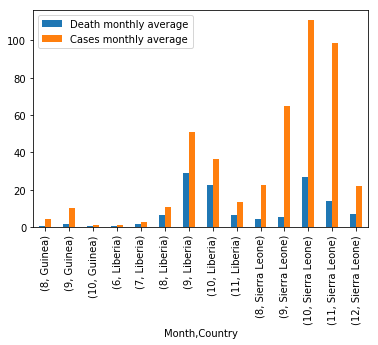

In [23]:
calculated_average_df.plot.bar(x=['Month','Country'])

# Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [214]:
all_files = glob.glob(DATA_FOLDER + '/microbiome' + '/MID*.xls')
raw_df = pd.DataFrame()

for file in all_files:
    file_name = file[file.rfind('/')+1:file.rfind('.')]
    temp_df = pd.read_excel(file, header=None)
    temp_df['BARCODE'] = file_name
    raw_df = raw_df.append(temp_df)

raw_df.head()

,0,1,BARCODE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID4
1,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",1,MID4
2,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID4
3,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID4
4,"Archaea ""Euryarchaeota"" Methanopyri Methanopyr...",10,MID4


In [215]:
metadata_df = pd.read_excel(DATA_FOLDER+'/microbiome'+'/metadata.xls')
metadata_df

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,NaN
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue
5,MID6,NEC 1,stool
6,MID7,Control 1,stool
7,MID8,NEC 2,stool
8,MID9,Control 2,stool


In [216]:
raw_df = pd.merge(raw_df, metadata_df[['BARCODE', 'GROUP']], on=['BARCODE'])
raw_df.rename(columns={0: 'Description', 1: 'Sample'}, inplace=True)

In [217]:
stool_metadata_df = metadata_df[metadata_df['SAMPLE'] == 'stool']
tissue_metadata_df = metadata_df[metadata_df['SAMPLE'] == 'tissue']
na_metadata_df = metadata_df[metadata_df['SAMPLE'].isnull()]

In [218]:
tissue_metadata_df

,BARCODE,GROUP,SAMPLE
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue


In [228]:
stool_df = raw_df[raw_df['BARCODE'].isin(list(stool_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
stool_df.rename(columns={'Sample': 'Stool'}, inplace=True)
tissue_df = raw_df[raw_df['BARCODE'].isin(list(tissue_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
tissue_df.rename(columns={'Sample': 'Tissue'}, inplace=True)
na_df = raw_df[raw_df['BARCODE'].isin(list(na_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
na_df.rename(columns={'Sample': 'Other'}, inplace=True)

In [229]:
stool_df.head()

,Description,Stool,GROUP
134,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,NEC 1
135,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1
136,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1
137,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,NEC 1
138,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5,NEC 1


In [230]:
merged_df = pd.merge(stool_df, tissue_df, how='outer', on=['Description', 'GROUP'])
merged_df

,Description,Stool,GROUP,Tissue
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7.0,NEC 1,23.0
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1.0,NEC 1,1.0
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1.0,NEC 1,NaN
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2.0,NEC 1,2.0
4,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5.0,NEC 1,10.0
5,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",4.0,NEC 1,11.0
6,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",4.0,NEC 1,9.0
7,"Archaea ""Crenarchaeota"" Thermoprotei Thermopro...",1.0,NEC 1,5.0
8,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",12.0,NEC 1,9.0
9,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",2.0,NEC 1,1.0


In [231]:
merged_df = pd.merge(merged_df, na_df, how='outer', on=['Description', 'GROUP'])

In [234]:
merged_df.fillna('unknown', inplace=True)

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [ ]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [ ]:
# Write your answer here